## Importing necessary libraries

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

### Loading dataset

In [2]:
data = pd.read_csv("housing.csv")

#### Making a copy to work with

In [3]:
housing_data = data

In [4]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Planting random seed to facilitate identical sampling

In [5]:
np.random.seed(42)

#### Creating additional attribute to help perform stratified sampling

In [6]:
housing_data["income_cat"] = pd.cut(housing_data["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_data, housing_data["income_cat"]):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

In [8]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Train Set

In [9]:
housing_X_train = strat_train_set.drop("median_house_value", axis=1)
housing_y_train = strat_train_set["median_house_value"].copy()

## Test Set

In [10]:
housing_X_test = strat_test_set.drop("median_house_value",axis=1)
housing_y_test = strat_test_set["median_house_value"].copy()

### Separating numerical and categorical attributes from the X_train set

In [11]:
housing_X_train_numerical = housing_X_train.drop("ocean_proximity", axis=1)

In [12]:
housing_X_train_categorical = housing_X_train[["ocean_proximity"]]

#### Defining imputer to fill in missing values

In [13]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

#### Defining one hot encoder for categorical variable "ocean proximity"

In [14]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

#### Defining class to add additional attributes (feature engineering)

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [housing_X_train_numerical.columns.get_loc(c) for c in col_names]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

#### Adding pipeline to perform few operations on the dataset

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler()),])

#### Adding column transformer to facilitate pipeline operations on both numerical and categorical attributes

In [17]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_X_train_numerical)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),("cat", OneHotEncoder(), cat_attribs),])

housing_X_train_prepared = full_pipeline.fit_transform(housing_X_train)

In [18]:
housing_X_train_prepared.shape

(16512, 16)

In [19]:
housing_y_train.shape

(16512,)

#### Defining Linear Regression Model, Decision Tree, Random Forest and Support Vector Machine

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
from sklearn.model_selection import cross_val_score

In [23]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

### Linear Regression

In [24]:
linear_reg = LinearRegression()

linear_reg.fit(housing_X_train_prepared, housing_y_train)

LinearRegression()

In [25]:
linear_crossval = cross_val_score(linear_reg, housing_X_train_prepared, housing_y_train,
                             scoring="neg_mean_squared_error", cv=5)
linear_rmse_scores = np.sqrt(-linear_crossval)
display_scores(linear_rmse_scores)

Scores: [68076.63768302 67881.16711321 69712.97514343 71266.9225777
 68390.25096271]
Mean: 69065.59069601326
Standard deviation: 1272.9445955637425


### Grid Search for Decision Tree

In [26]:
tree_reg_gridsearch = DecisionTreeRegressor(random_state=42)

In [27]:
param_grid = [{'max_depth': [1, 5, 10], 'min_samples_split': [5,10], 'min_samples_leaf': [1,5,10],
               'max_leaf_nodes': [5,10,50], 'min_weight_fraction_leaf': [0.0, 0.5], 'ccp_alpha': [0.0, 0.01, 0.05, 0.1]}]


tree_grid_search = GridSearchCV(tree_reg_gridsearch, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

tree_grid_search.fit(housing_X_train_prepared, housing_y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid=[{'ccp_alpha': [0.0, 0.01, 0.05, 0.1],
                          'max_depth': [1, 5, 10],
                          'max_leaf_nodes': [5, 10, 50],
                          'min_samples_leaf': [1, 5, 10],
                          'min_samples_split': [5, 10],
                          'min_weight_fraction_leaf': [0.0, 0.5]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [28]:
tree_grid_search.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 10,
 'max_leaf_nodes': 50,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0}

### Grid Search for Random Forest

In [29]:
random_reg_gridsearch = RandomForestRegressor(random_state=42)

param_grid = [{'bootstrap': [True], 'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}]

random_grid_search = GridSearchCV(random_reg_gridsearch, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

random_grid_search.fit(housing_X_train_prepared, housing_y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'bootstrap': [True], 'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [30]:
random_grid_search.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 30}

### Grid Search for Support Vector Machine

In [31]:
param_grid = [{'kernel': ['linear'], 'C': [10., 100., 1000., 10000.]},
        {'kernel': ['rbf'], 'C': [1.0, 10., 100., 1000.0],'gamma': [0.01, 0.1, 1.0]}]

svm_reg_gridsearch = SVR()

svm_grid_search = GridSearchCV(svm_reg_gridsearch, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

svm_grid_search.fit(housing_X_train_prepared, housing_y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..............................C=10.0, kernel=linear; total time=   8.4s
[CV] END ..............................C=10.0, kernel=linear; total time=   5.5s
[CV] END ..............................C=10.0, kernel=linear; total time=   5.0s
[CV] END ..............................C=10.0, kernel=linear; total time=   5.0s
[CV] END ..............................C=10.0, kernel=linear; total time=   5.0s
[CV] END .............................C=100.0, kernel=linear; total time=   5.0s
[CV] END .............................C=100.0, kernel=linear; total time=   4.9s
[CV] END .............................C=100.0, kernel=linear; total time=   4.9s
[CV] END .............................C=100.0, kernel=linear; total time=   5.1s
[CV] END .............................C=100.0, kernel=linear; total time=   5.0s
[CV] END ............................C=1000.0, kernel=linear; total time=   5.1s
[CV] END ............................C=1000.0, k

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 100.0, 1000.0, 10000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 10.0, 100.0, 1000.0],
                          'gamma': [0.01, 0.1, 1.0], 'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [32]:
svm_grid_search.best_params_

{'C': 10000.0, 'kernel': 'linear'}

### Random Search for Decision Tree

In [33]:
from sklearn.model_selection import RandomizedSearchCV

tree_reg_randsearch = DecisionTreeRegressor(random_state=42)

param_distribs = [{'max_depth': [1, 5, 10], 'min_samples_split': [5,10], 'min_samples_leaf': [1,5,10],
               'max_leaf_nodes': [5,10,50], 'min_weight_fraction_leaf': [0.0, 0.5], 'ccp_alpha': [0.0, 0.01, 0.05, 0.1]}]


tree_randsearch = RandomizedSearchCV(tree_reg_randsearch, param_distributions=param_distribs,
                           n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

tree_randsearch.fit(housing_X_train_prepared, housing_y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
                   param_distributions=[{'ccp_alpha': [0.0, 0.01, 0.05, 0.1],
                                         'max_depth': [1, 5, 10],
                                         'max_leaf_nodes': [5, 10, 50],
                                         'min_samples_leaf': [1, 5, 10],
                                         'min_samples_split': [5, 10],
                                         'min_weight_fraction_leaf': [0.0,
                                                                      0.5]}],
                   random_state=42, scoring='neg_mean_squared_error')

In [34]:
tree_randsearch.best_params_

{'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_leaf_nodes': 50,
 'max_depth': 10,
 'ccp_alpha': 0.1}

### Random Search for Random Forest

In [35]:
from scipy.stats import randint

param_distribs = [{'bootstrap': [True], 'n_estimators': randint(low=3, high=200), 'max_features': randint(low=1, high=8)},
              {'bootstrap': [False], 'n_estimators': randint(low=3, high=200), 'max_features': randint(low=1, high=8)}]

random_reg_randsearch = RandomForestRegressor(random_state=42)

random_randsearch = RandomizedSearchCV(random_reg_randsearch, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

random_randsearch.fit(housing_X_train_prepared, housing_y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions=[{'bootstrap': [True],
                                         'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C8731EDCC0>,
                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C872D89330>},
                                        {'bootstrap': [False],
                                         'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C872D4EA10>,
                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C8731EC9D0>}],
                   random_state=42, scoring='neg_mean_squared_error')

In [36]:
random_randsearch.best_params_

{'bootstrap': False, 'max_features': 6, 'n_estimators': 40}

### Random Search for Support Vector Machine

In [37]:
param_distribs = [{'kernel': ['linear'], 'C': randint(low=10, high=10000)},
        {'kernel': ['rbf'], 'C': randint(low=1, high=1000),'gamma': [0.01, 0.1, 1.0]}]

svm_reg_randsearch = SVR()

svm_randsearch = RandomizedSearchCV(svm_reg_randsearch, param_distributions=param_distribs,
                                    cv=5, scoring='neg_mean_squared_error', verbose=2)

svm_randsearch.fit(housing_X_train_prepared, housing_y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .......................C=509, gamma=1.0, kernel=rbf; total time=  13.1s
[CV] END .......................C=509, gamma=1.0, kernel=rbf; total time=   9.3s
[CV] END .......................C=509, gamma=1.0, kernel=rbf; total time=   9.3s
[CV] END .......................C=509, gamma=1.0, kernel=rbf; total time=   9.3s
[CV] END .......................C=509, gamma=1.0, kernel=rbf; total time=   9.3s
[CV] END ..............................C=3162, kernel=linear; total time=   5.5s
[CV] END ..............................C=3162, kernel=linear; total time=   5.7s
[CV] END ..............................C=3162, kernel=linear; total time=   5.6s
[CV] END ..............................C=3162, kernel=linear; total time=   5.7s
[CV] END ..............................C=3162, kernel=linear; total time=   5.6s
[CV] END .......................C=562, gamma=0.1, kernel=rbf; total time=   9.5s
[CV] END .......................C=562, gamma=0.1

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C8731ABBE0>,
                                         'kernel': ['linear']},
                                        {'C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C830A680D0>,
                                         'gamma': [0.01, 0.1, 1.0],
                                         'kernel': ['rbf']}],
                   scoring='neg_mean_squared_error', verbose=2)

In [38]:
svm_randsearch.best_params_

{'C': 9477, 'kernel': 'linear'}

## Fitting Decision Tree Regression Model with optimal hyperparameters obtained from Grid Search and Random Search 

In [39]:
tree_retrain_grid = DecisionTreeRegressor(ccp_alpha=0.0, max_depth=10, max_leaf_nodes=50,
                                          min_samples_leaf=5, min_samples_split=5, min_weight_fraction_leaf=0.0)

In [40]:
tree_scores_grid = cross_val_score(tree_retrain_grid, housing_X_train_prepared, housing_y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores_grid = np.sqrt(-tree_scores_grid)
display_scores(tree_rmse_scores_grid)

Scores: [63795.79907257 60699.19743093 59563.81329264 66112.41901048
 59624.05827777 64599.907839   63923.96731544 63475.51568326
 60307.26092361 66861.3037524 ]
Mean: 62896.32425981046
Standard deviation: 2539.902793246419


In [41]:
tree_retrain_rand = DecisionTreeRegressor(min_weight_fraction_leaf=0.0, min_samples_split=5,
                                          min_samples_leaf=5, max_leaf_nodes=50, max_depth=10, ccp_alpha=0.1)

In [42]:
tree_scores_rand = cross_val_score(tree_retrain_rand, housing_X_train_prepared, housing_y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores_rand = np.sqrt(-tree_scores_rand)
display_scores(tree_rmse_scores_rand)

Scores: [63795.79907257 60699.19743093 59563.81329264 66112.41901048
 59624.05827777 64599.907839   63923.96731544 63475.51568326
 60307.26092361 66861.3037524 ]
Mean: 62896.32425981046
Standard deviation: 2539.902793246419


## Fitting Random Forest Regression Model with optimal hyperparameters obtained from Grid Search and Random Search 

In [43]:
random_retrain_grid = RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=30)

In [44]:
random_scores_grid = cross_val_score(random_retrain_grid, housing_X_train_prepared, housing_y_train,
                         scoring="neg_mean_squared_error", cv=10)
random_rmse_scores_grid = np.sqrt(-random_scores_grid)
display_scores(random_rmse_scores_grid)

Scores: [51071.53590127 47955.57868035 46128.02749472 50770.62266515
 47571.23719912 50583.36480772 50955.27380433 48549.37915733
 47278.47086044 52926.63852017]
Mean: 49379.01290905994
Standard deviation: 2056.3466249631974


In [45]:
random_retrain_rand = RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=40)

In [46]:
random_scores_rand = cross_val_score(random_retrain_rand, housing_X_train_prepared, housing_y_train,
                         scoring="neg_mean_squared_error", cv=10)
random_rmse_scores_rand = np.sqrt(-random_scores_rand)
display_scores(random_rmse_scores_rand)

Scores: [50889.50947781 47179.83784895 46135.34105595 49430.69655588
 46098.10999009 48292.75398964 49674.02395958 47266.39547163
 47239.67173355 52627.65711313]
Mean: 48483.399719619556
Standard deviation: 2030.9051050882642


## Fitting Support Vector Machine Regression Model with optimal hyperparameters obtained from Grid Search and Random Search 

In [47]:
svm_retrain_grid = SVR(C=10000.0, kernel='linear')

In [48]:
svm_scores_grid = cross_val_score(svm_retrain_grid, housing_X_train_prepared, housing_y_train,
                         scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores_grid = np.sqrt(-svm_scores_grid)
display_scores(svm_rmse_scores_grid)

Scores: [72594.25749668 66077.21607085 67127.38810235 70239.3677623
 67134.74071207 73922.46981788 77137.8945368  70000.30379852
 67545.14984035 70930.05529475]
Mean: 70270.88434325633
Standard deviation: 3333.6185955727083


In [49]:
svm_retrain_rand = SVR(C=9477, kernel='linear')

In [50]:
svm_scores_rand = cross_val_score(svm_retrain_rand, housing_X_train_prepared, housing_y_train,
                         scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores_rand = np.sqrt(-svm_scores_rand)
display_scores(svm_rmse_scores_rand)

Scores: [72595.29279877 66079.38019098 67118.97210981 70243.06518784
 67134.32591361 73921.24348722 77136.9234861  69999.86322018
 67545.08310326 70930.15651512]
Mean: 70270.43060128957
Standard deviation: 3333.9256608354085


### Evaluating RMSE and R2 score for all the models

In [51]:
from sklearn.metrics import r2_score

### For Linear Regression

In [52]:
linear_rmse = linear_rmse_scores
linear_retrain = LinearRegression()

In [53]:
linear_retrain.fit(housing_X_train_prepared, housing_y_train)
linear_pred = linear_retrain.predict(housing_X_train_prepared)

In [54]:
linear_r2 = r2_score(housing_y_train, linear_pred)

In [55]:
print(linear_r2)

0.6481553634454353


### For Decision Tree

In [56]:
tree_retrain_grid.fit(housing_X_train_prepared, housing_y_train)

DecisionTreeRegressor(max_depth=10, max_leaf_nodes=50, min_samples_leaf=5,
                      min_samples_split=5)

In [57]:
tree_retrain_rand.fit(housing_X_train_prepared, housing_y_train)

DecisionTreeRegressor(ccp_alpha=0.1, max_depth=10, max_leaf_nodes=50,
                      min_samples_leaf=5, min_samples_split=5)

In [58]:
tree_rmse_grid = np.sqrt(sum(-tree_scores_grid)/len(tree_scores_grid))

In [59]:
tree_grid_pred = tree_retrain_grid.predict(housing_X_train_prepared)

In [60]:
tree_grid_r2 = r2_score(housing_y_train,tree_grid_pred)

In [61]:
tree_rmse_rand = np.sqrt(sum(-tree_scores_rand)/len(tree_scores_rand))

In [62]:
tree_rand_pred = tree_retrain_rand.predict(housing_X_train_prepared)

In [63]:
tree_rand_r2 = r2_score(housing_y_train,tree_rand_pred)

### For Random Forest

In [64]:
random_retrain_grid.fit(housing_X_train_prepared, housing_y_train)

RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=30)

In [65]:
random_retrain_rand.fit(housing_X_train_prepared, housing_y_train)

RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=40)

In [66]:
random_rmse_grid = np.sqrt(sum(-random_scores_grid)/len(random_scores_grid))

In [67]:
random_grid_pred = random_retrain_grid.predict(housing_X_train_prepared)

In [68]:
random_grid_r2 = r2_score(housing_y_train,random_grid_pred)

In [69]:
random_rmse_rand = np.sqrt(sum(-random_scores_rand)/len(random_scores_rand))

In [70]:
random_rand_pred = random_retrain_rand.predict(housing_X_train_prepared)

In [71]:
random_rand_r2 = r2_score(housing_y_train,random_rand_pred)

### For Support Vector Machine

In [72]:
svm_retrain_grid.fit(housing_X_train_prepared, housing_y_train)

SVR(C=10000.0, kernel='linear')

In [73]:
svm_retrain_rand.fit(housing_X_train_prepared, housing_y_train)

SVR(C=9477, kernel='linear')

In [74]:
svm_rmse_grid = np.sqrt(sum(-svm_scores_grid)/len(svm_scores_grid))

In [75]:
svm_grid_pred = svm_retrain_grid.predict(housing_X_train_prepared)

In [76]:
svm_grid_r2 = r2_score(housing_y_train,svm_grid_pred)

In [77]:
svm_rmse_rand = np.sqrt(sum(-svm_scores_rand)/len(svm_scores_rand))

In [78]:
svm_rand_pred = svm_retrain_rand.predict(housing_X_train_prepared)

In [79]:
svm_rand_r2 = r2_score(housing_y_train,svm_rand_pred)

### Now combining all the scores into lists

In [80]:
rmse_scores = [tree_rmse_grid,tree_rmse_rand,random_rmse_grid,random_rmse_rand,svm_rmse_grid,svm_rmse_rand]

In [81]:
r2_scores = [tree_grid_r2,tree_rand_r2,random_grid_r2,random_rand_r2,svm_grid_r2,svm_rand_r2]

In [82]:
print(rmse_scores)

[62947.587019633735, 62947.587019633735, 49421.8117567042, 48525.917033254285, 70349.91257509888, 70349.47389428459]


In [83]:
print(r2_scores)

[0.7309114004507317, 0.7309114004507317, 1.0, 1.0, 0.6320836765382409, 0.6320938176750993]


In [ ]:
grid_rmse_scores = [tree_rmse_grid,random_rmse_grid,svm_rmse_grid]
rand_rmse_scores = [tree_rmse_rand,random_rmse_rand,svm_rmse_rand]

grid_r2_score = [tree_grid_r2,random_grid_r2,svm_grid_r2]
rand_r2_score = [tree_rand_r2,random_rand_r2,svm_rand_r2]

### Plotting the values for comparison

In [84]:
models = {
    
    "Decision Tree - Grid Search": DecisionTreeRegressor(max_depth=10, max_leaf_nodes=50, min_samples_leaf=5,
                      min_samples_split=5,random_state=42),
    "Decision Tree - Random Search": DecisionTreeRegressor(ccp_alpha=0.1, max_depth=10, max_leaf_nodes=50,
                      min_samples_leaf=5, min_samples_split=5,random_state=42),
    "Random Forest - Grid Search": RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=30,random_state=42),
    "Random Forest - Random Search": RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=40, random_state=42),
    "SVR - Grid Search": SVR(C=10000.0, kernel='linear'),
    "SVR - Random Search": SVR(C=9477, kernel='linear')
}

model_names = list(models.keys())

In [85]:
import os
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="jpg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

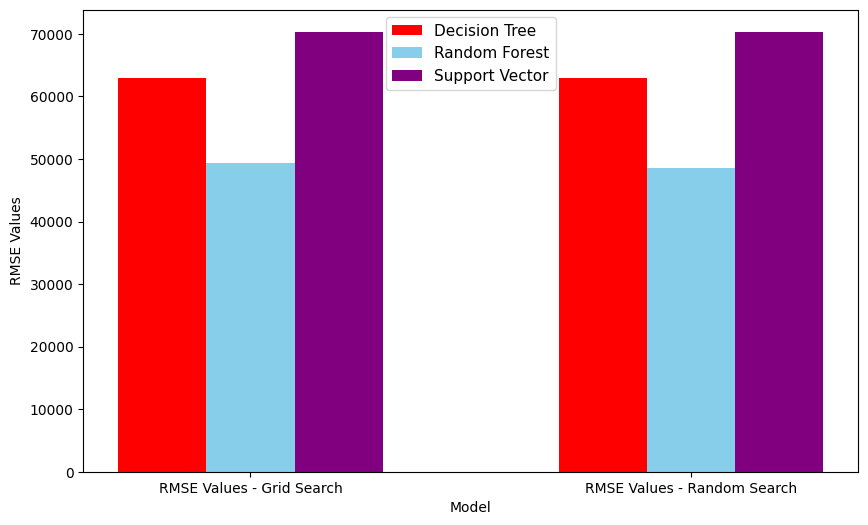

In [86]:
x = np.arange(2)
y1 = [tree_rmse_grid,tree_rmse_rand]
y2 = [random_rmse_grid,random_rmse_rand]
y3 = [svm_rmse_grid,svm_rmse_rand]
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x-0.2, y1, width, color='red') 
plt.bar(x, y2, width, color='skyblue') 
plt.bar(x+0.2, y3, width, color='purple') 
plt.xticks(x, ['RMSE Values - Grid Search', 'RMSE Values - Random Search']) 
plt.xlabel("Model") 
plt.ylabel("RMSE Values") 
plt.legend(["Decision Tree", "Random Forest", "Support Vector"],loc="upper center",fontsize=11) 
plt.show() 

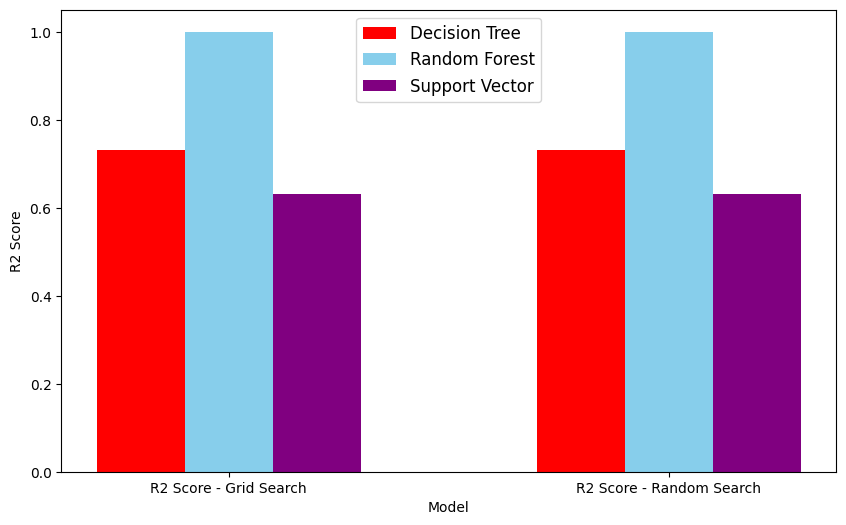

In [87]:
x = np.arange(2)
y1 = [tree_grid_r2,tree_rand_r2]
y2 = [random_grid_r2,random_rand_r2]
y3 = [svm_grid_r2,svm_rand_r2]
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x-0.2, y1, width, color='red') 
plt.bar(x, y2, width, color='skyblue') 
plt.bar(x+0.2, y3, width, color='purple') 
plt.xticks(x, ['R2 Score - Grid Search', 'R2 Score - Random Search']) 
plt.xlabel("Model") 
plt.ylabel("R2 Score") 
plt.legend(["Decision Tree", "Random Forest", "Support Vector"],loc="upper center",fontsize=12) 
plt.show() 

## Here we can see that Random Forest (Random Search) yields the best result! So we use the "Test Set" to predict the values and find the metrics of accuracy (RMSE and R2 score)

In [88]:
best_model = RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=40, random_state=42)

In [89]:
best_model.fit(housing_X_train_prepared, housing_y_train)

RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=40,
                      random_state=42)

In [90]:
housing_X_test_prepared = full_pipeline.fit_transform(housing_X_test)

In [91]:
final_prediction = best_model.predict(housing_X_test_prepared)

In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [93]:
final_mse = mean_squared_error(housing_y_test, final_prediction)

In [94]:
print(final_mse)

4541713184.984454


In [95]:
final_rmse = np.sqrt(final_mse)

In [96]:
print(final_rmse)

67392.23386254869


In [97]:
final_model_r2_score = r2_score(housing_y_test, final_prediction)

In [98]:
print(final_model_r2_score)

0.6515260598456449


### Prediction using test data for Linear Regression along with RMSE and R2 score

In [101]:
lin_test_pred = linear_retrain.predict(housing_X_test_prepared)

In [102]:
linear_test_rmse = np.sqrt(mean_squared_error(housing_y_test,lin_test_pred))

In [103]:
linear_test_r2 = r2_score(housing_y_test,lin_test_pred)

In [104]:
print(linear_test_rmse,linear_test_r2)

66975.77789893825 0.6558196004845205


### Prediction using test data for Decision Tree Regression along with RMSE and R2 score

In [105]:
tree_test_pred = tree_retrain_rand.predict(housing_X_test_prepared)

In [106]:
tree_test_rmse = np.sqrt(mean_squared_error(housing_y_test,tree_test_pred))

In [108]:
tree_test_r2 = r2_score(housing_y_test,tree_test_pred)

In [109]:
print(tree_test_rmse,tree_test_r2)

81156.6304206471 0.4946426162498273


### Prediction using test data for Support Vector Machine along with RMSE and R2 score

In [110]:
svm_test_pred = svm_retrain_rand.predict(housing_X_test_prepared)

In [111]:
svm_test_rmse = np.sqrt(mean_squared_error(housing_y_test,svm_test_pred))

In [112]:
svm_test_r2 = r2_score(housing_y_test,svm_test_pred)

In [113]:
print(svm_test_rmse,svm_test_r2)

68233.28524737363 0.642773914020387


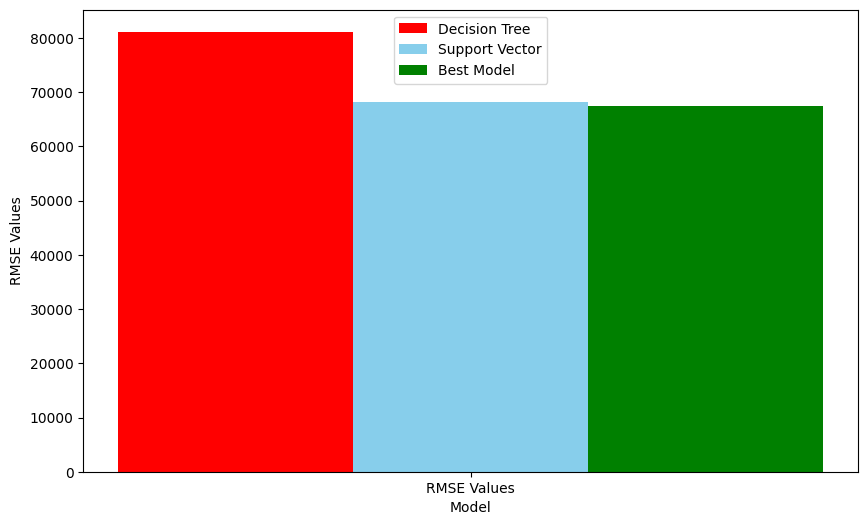

In [136]:
x = np.arange(1)
y1 = [tree_test_rmse]
y2 = [svm_test_rmse]
y3 = [final_rmse]

width = 0.1

plt.figure(figsize=(10, 6))
plt.bar(x-0.1, y1, width, color='red') 
plt.bar(x, y2, width, color='skyblue') 
plt.bar(x+0.1, y3, width, color='green')


plt.xticks(x, ['RMSE Values']) 
plt.xlabel("Model") 
plt.ylabel("RMSE Values") 
plt.legend(["Decision Tree", "Support Vector", "Best Model"],loc="upper center",fontsize=10)
plt.show() 

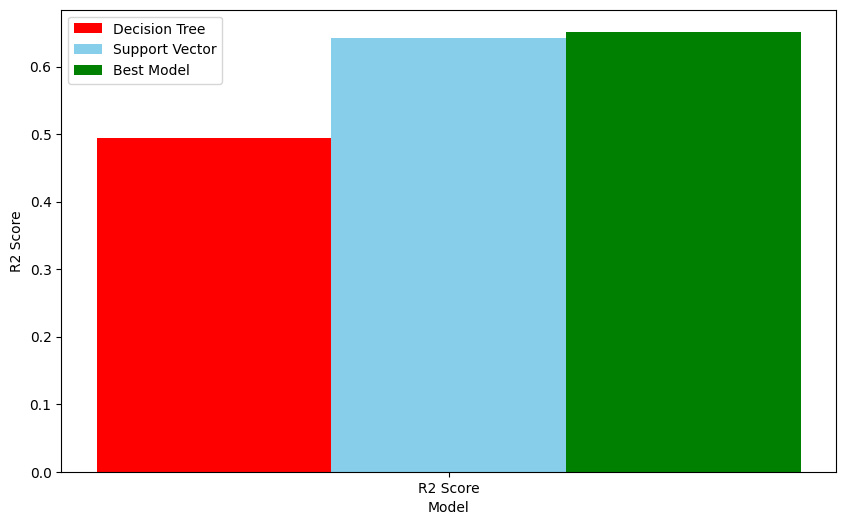

In [139]:
x = np.arange(1)
y1 = [tree_test_r2]
y2 = [svm_test_r2]
y3 = [final_model_r2_score]

width = 0.1

plt.figure(figsize=(10, 6))
plt.bar(x-0.1, y1, width, color='red') 
plt.bar(x, y2, width, color='skyblue') 
plt.bar(x+0.1, y3, width, color='green')


plt.xticks(x, ['R2 Score']) 
plt.xlabel("Model") 
plt.ylabel("R2 Score") 
plt.legend(["Decision Tree", "Support Vector", "Best Model"],loc="upper left",fontsize=10)
plt.show() 

### RMSE value of Decision Tree Regressor does not yield better result than Random Forest model. Hence, Random Forest - Random Search Model is the best performing model.